# Information sur la machine

In [1]:
import tensorflow as tf
tf.test.gpu_device_name()

''

In [5]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14337207419761233370]

device_lib.list_local_devices() nous permet de lister les périphériques disponibles dans le processus local.
Par exemple on aperçoit qu'il y a le CPU qui est disponible avec une mémoire limite de 268435456.

In [3]:
!nvidia-smi

Thu Mar 03 15:43:45 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 398.35                 Driver Version: 398.35                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1060   WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   68C    P8     6W /  N/A |     92MiB /  6144MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

On observe qu'on a les informations sur le CPU et le GPU.
Sur la machine, on a un GPU FetForce GTX 1060 

Par la suite, j'ai fais fonctionné les lignes de commande en restant sur le CPU. On peut biensure lancer les lignes de commandes en GPU pour gagner en vitesse de calcul.

# Importation et préparation des données

On commence par importer les packages nécessaires pour qu'on puisse implémenter notre réseau de neurones.

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator #modification sur l'image
from tensorflow.keras.models import Sequential #construction de modèle
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense #utile à l'intérieur du réseau 
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow import keras #librairie pour le deep learning
from tensorflow.keras import layers #librairie pour les couches
import matplotlib.pyplot as plt #affichage graphique

import tensorflow as tf


On importe nos données d'apprentissage $\textbf{train}$ et et nos données de validation $\textbf{validation}$ 

In [3]:
train_data_dir = 'C:/Users/na_to/OneDrive/Bureau/Insa/Mapromo/ML3/Exercices/Data/chihuahua-vs-muffin/train'
validation_data_dir = 'C:/Users/na_to/OneDrive/Bureau/Insa/Mapromo/ML3/Exercices/Data/chihuahua-vs-muffin/validation'

    On définit la taille de nos images en largeur et en longeur (256,256).
    La batchsize définit le nombre d'échantillons qui vont être propagés à travers le réseau. Ici il est à 32. 
    On a 32 images à chaque fois qui intervienent dans les couches.

    label_mode = 'categorical' signifie que les étiquettes sont encodées sous forme de vecteur categorical. 

In [4]:
image_size = (256, 256)
batch_size = 32 #Taille du batch , 32 images à chaque fois qui rentre dans le réseau 

train_ds = keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    image_size=image_size,
    batch_size=batch_size,
    label_mode = 'categorical'
)
val_ds = keras.preprocessing.image_dataset_from_directory(
    validation_data_dir,
    image_size=image_size,
    batch_size=batch_size,
    label_mode = 'categorical'
)

Found 568 files belonging to 2 classes.
Found 142 files belonging to 2 classes.


On a 568 images dans le train avec 2 classes muffin et chihuahua.
On a 142 images dans la validation avec 2 classes muffin et chihuahua

In [5]:
class_names = train_ds.class_names

In [6]:
class_names

['chihuahua', 'muffin']

# Affichage des images

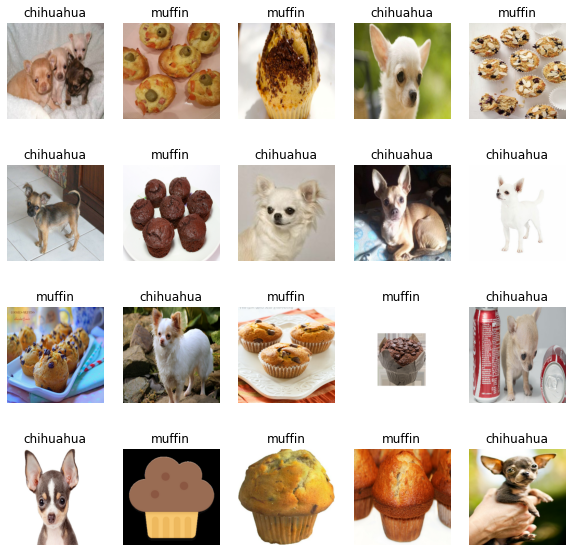

In [31]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(20):
        ax = plt.subplot(4, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[tf.argmax(labels[i])])
        plt.axis("off")

On affiche 20 images aléatoirement qui sont présent dans la base d'entrainement. Ces images présentent des muffins ou des chihuahuas

In [9]:
img_height, img_width = image_size
input_shape = (img_height, img_width, 3)

On définit la taille des images à l'entrée du réseau. Les images à l'entrées sont de taille (256,256,3)

In [10]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal", input_shape=input_shape),
        layers.RandomRotation(0.1),
    ]
)

On peut augmenter la base de données initiale de différente façon. Ici on retourne les images de manière horizontal et on fait une lègère rotation sur les images. On ajoutera ces données supplémentaire dans le réseau

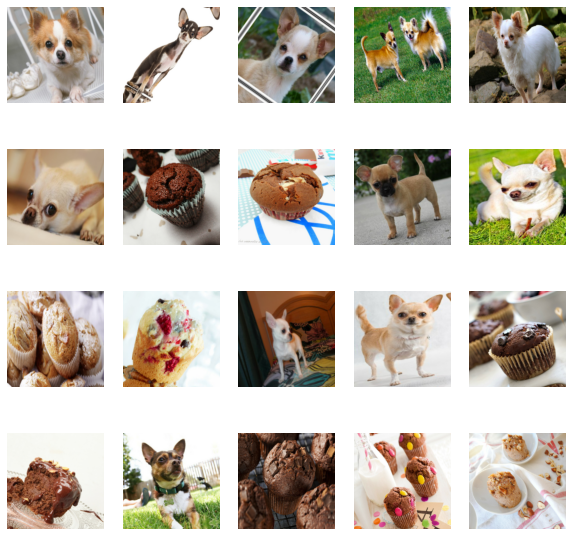

In [32]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(20):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(4, 5, i + 1)
        plt.imshow(augmented_images[i].numpy().astype("uint8"))
        plt.axis("off")

On affiche 20 images de la data augmentation. Ces images sont les données qui ont été modifié

In [12]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [34]:
print(train_ds)
print(val_ds)

<PrefetchDataset shapes: ((None, 256, 256, 3), (None, 2)), types: (tf.float32, tf.float32)>
<PrefetchDataset shapes: ((None, 256, 256, 3), (None, 2)), types: (tf.float32, tf.float32)>


On a maintenant les variables train_ds et val_ds qui sont pret à être modélisé

# Modélisation

Notre réseau de neurone de convolution prend en entrée notre image de taille (None,256,256,3). Le chiffre 3 correpond aux 3 couleurs : rouge, vert et bleu. None s'agit du batch size.

Les données sont mises à la même échelle grâce à layers.Rescaling(1./255)

On construit un réseau avec 4 couches cachées. La fonction d'activation utilisé est relu, qui prennent les valeurs entre 0 et +infini. On effectue à chaque fois un maxPooling2D pour chaque couche cachée. On sous-échantillonne l'entrée selon ses dimensions spatiales (hauteur et largeur) en prenant la valeur maximale sur une fenêtre d'entrée (de taille définie par pool_size) pour chaque canal de l'entrée.

Les couches sont ensuite full connecté et on ajoute un droupout en desactivant 50% des neurones de la couche. 

On a deux valeurs en sortie car on a 2 classes. Cela correpond à la probabilité d'obtenir à un muffin ou à un chihuahua, pour cela la fonction softmax est utilisé.

In [12]:
model = Sequential()
# Preprocessing
model.add(data_augmentation)
model.add(layers.Rescaling(1./255))

# Model
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(2))
model.add(Activation('softmax'))

On compile notre modèle en utilisant l'optimiseur adam, la fonction de perte "categorical_crossentropy" car il s'agit d'un problème multiclass et comme metrics on utilise l'accuracy car on cherche à prédire des variables discréte, on a un problème de classification.

La fonction de perte est utilisée pour optimiser un algorithme d'apprentissage automatique. La perte est calculée sur la formation et la validation et son interprétation est basée sur la performance du modèle dans ces deux datasets. C'est la somme des erreurs commises pour chaque exemple dans les ensembles d'apprentissage ou de validation. La valeur de perte implique à quel point un modèle se comporte mal ou bien après chaque itération d'optimisation. 

La métrique accuracy est utilisée pour mesurer les performances de l'algorithme de manière interprétable. La métrique accuracy d'un modèle est calculée sous la forme d'un pourcentage. C'est la mesure de la précision de la prédiction du modèle par rapport aux données réelles. 

In [13]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 254, 254, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      9248      
_________________________________________________________________
activation_1 (Activation)    (None, 125, 125, 32)     

On observe qu'on a au total 840 898 paramètres dans notre modèle.

In [19]:
epochs = 10
hist = model.fit(train_ds.repeat(), epochs=epochs, steps_per_epoch=50, validation_data=val_ds)

Epoch 1/10
50/50 [==============================] - 62s 1s/step - loss: 0.2755 - accuracy: 0.8952 - val_loss: 0.3580 - val_accuracy: 0.8239
Epoch 2/10
50/50 [==============================] - 61s 1s/step - loss: 0.2694 - accuracy: 0.8934 - val_loss: 0.2562 - val_accuracy: 0.8803
Epoch 3/10
50/50 [==============================] - 60s 1s/step - loss: 0.2318 - accuracy: 0.9143 - val_loss: 0.1835 - val_accuracy: 0.9366
Epoch 4/10
50/50 [==============================] - 59s 1s/step - loss: 0.2119 - accuracy: 0.9264 - val_loss: 0.2069 - val_accuracy: 0.9014
Epoch 5/10
50/50 [==============================] - 59s 1s/step - loss: 0.1783 - accuracy: 0.9426 - val_loss: 0.1866 - val_accuracy: 0.9155
Epoch 6/10
50/50 [==============================] - 61s 1s/step - loss: 0.1931 - accuracy: 0.9346 - val_loss: 0.1898 - val_accuracy: 0.9437
Epoch 7/10
50/50 [==============================] - 63s 1s/step - loss: 0.1605 - accuracy: 0.9416 - val_loss: 0.1954 - val_accuracy: 0.9296
Epoch 8/10
50/50 [==

## L'évolution des pertes et des accuracy de validation et d'entraînement

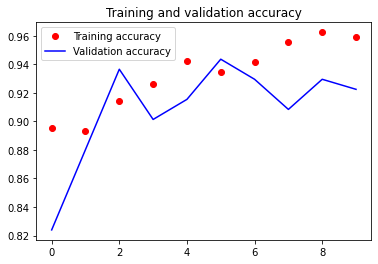

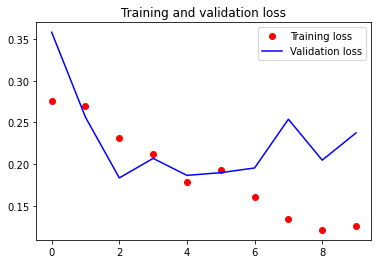

In [20]:
accuracy = hist.history["accuracy"]
val_accuracy = hist.history["val_accuracy"]
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'ro', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

On remarque qu'on a un sur-apprentissage des données à partir de la 6ème époch dans les deux graphiques.A partir de la 6ème epoch l'ecart devient plus important entre le training loss/validation loss et training accuracy/Validation accuracy. Au fur et à mesure le training loss devient moins importante que la validation loss et le training accuracy devient plus important que la validation accuracy. Il serait intéressant de faire un drapout pour éviter le sur-apprentissage ou de réduire le nombre d'époch en mettant à 6 par exemple

muffin


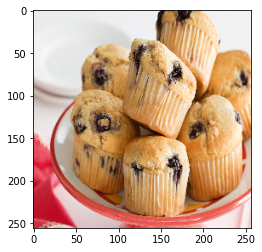

In [21]:
img_url = 'C:/Users/na_to/OneDrive/Bureau/Insa/Mapromo/ML3/Exercices/Data/chihuahua-vs-muffin/validation/muffin/ActiOn_3.jpeg'
img = keras.preprocessing.image.load_img(img_url, target_size=image_size)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
class_prediction = np.argmax(predictions)
plt.imshow(img)
print(class_names[class_prediction])

On observe bien que pour une image de validation. Le modèle a bien prédit le muffin sur l'image

## Performance sur les données Test 

Il serait maintenant intéressant d'utiliser les performances du modèle sur un nouveau jeu de données Test.

In [13]:
test_data_dir = 'C:/Users/na_to/OneDrive/Bureau/Insa/Mapromo/ML3/Exercices/Data/chihuahua-vs-muffin/test' 

In [14]:
test_ds = keras.preprocessing.image_dataset_from_directory(
    test_data_dir,
    image_size=image_size,
    batch_size=batch_size,
    label_mode = 'categorical'
)

Found 16 files belonging to 2 classes.


On a bien 16 images qui sont présentes sur le fichier test avec 2 classes : muffin et chihuahua.

In [15]:
test_ds = val_ds.prefetch(buffer_size=32)

model.evaluate : Renvoie la valeur de perte et les valeurs de métriques pour le modèle en mode test. 

In [46]:
model.evaluate(test_ds)

5/5 [==============================] - 2s 184ms/step - loss: 0.2374 - accuracy: 0.9225


[0.23742517828941345, 0.922535240650177]

On obtient un accuracy de 92.25%

# Model avec Dropout 

On va cette fois-ci rendre à chaque fois 10% des neurones inactifs dans les couches.

In [22]:
model_bis = Sequential()
# Preprocessing
model_bis.add(data_augmentation)
model_bis.add(layers.Rescaling(1./255))

# Model
model_bis.add(Conv2D(32, (3, 3)))
model_bis.add(Activation('relu'))
model_bis.add(MaxPooling2D(pool_size=(2, 2)))
model_bis.add(Dropout(0.1))

model_bis.add(Conv2D(32, (3, 3)))
model_bis.add(Activation('relu'))
model_bis.add(MaxPooling2D(pool_size=(2, 2)))
model_bis.add(Dropout(0.1))

model_bis.add(Conv2D(32, (3, 3)))
model_bis.add(Activation('relu'))
model_bis.add(MaxPooling2D(pool_size=(2, 2)))
model_bis.add(Dropout(0.1))

model_bis.add(Conv2D(64, (3, 3)))
model_bis.add(Activation('relu'))
model_bis.add(MaxPooling2D(pool_size=(2, 2)))
model_bis.add(Dropout(0.1))

model_bis.add(Flatten())
model_bis.add(Dense(64))
model_bis.add(Activation('relu'))
model_bis.add(Dropout(0.1))

model_bis.add(Dense(2))
model_bis.add(Activation('softmax'))

In [23]:
model_bis.compile(
    optimizer=keras.optimizers.Adam(),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [24]:
epochs = 10
hist_bis = model_bis.fit(train_ds.repeat(), epochs=epochs, steps_per_epoch=50, validation_data=val_ds)

Epoch 1/10
50/50 [==============================] - 68s 1s/step - loss: 0.5420 - accuracy: 0.7165 - val_loss: 0.3870 - val_accuracy: 0.8521
Epoch 2/10
50/50 [==============================] - 74s 1s/step - loss: 0.3276 - accuracy: 0.8566 - val_loss: 0.3072 - val_accuracy: 0.8662
Epoch 3/10
50/50 [==============================] - 80s 2s/step - loss: 0.2960 - accuracy: 0.8858 - val_loss: 0.2766 - val_accuracy: 0.9366
Epoch 4/10
50/50 [==============================] - 71s 1s/step - loss: 0.2508 - accuracy: 0.8915 - val_loss: 0.3294 - val_accuracy: 0.8521
Epoch 5/10
50/50 [==============================] - 82s 2s/step - loss: 0.2018 - accuracy: 0.9179 - val_loss: 0.2398 - val_accuracy: 0.8873
Epoch 6/10
50/50 [==============================] - 72s 1s/step - loss: 0.2028 - accuracy: 0.9194 - val_loss: 0.1735 - val_accuracy: 0.9296
Epoch 7/10
50/50 [==============================] - 69s 1s/step - loss: 0.1894 - accuracy: 0.9181 - val_loss: 0.1830 - val_accuracy: 0.9366
Epoch 8/10
50/50 [==

## L'évolution des pertes et des accuracy de validation et d'entraînement

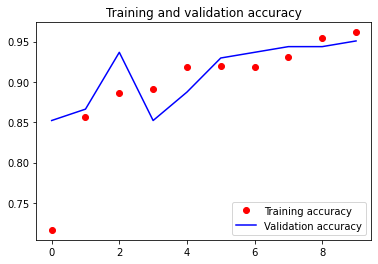

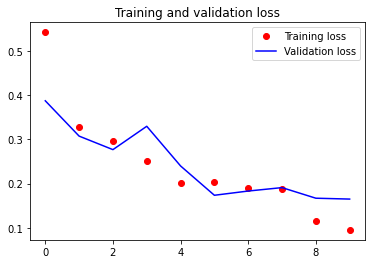

In [25]:
accuracy_bis = hist_bis.history["accuracy"]
val_accuracy_bis = hist_bis.history["val_accuracy"]
loss_bis = hist_bis.history['loss']
val_loss_bis = hist_bis.history['val_loss']
epochs_bis = range(len(accuracy_bis))
plt.plot(epochs_bis, accuracy_bis, 'ro', label='Training accuracy')
plt.plot(epochs_bis, val_accuracy_bis, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs_bis, loss_bis, 'ro', label='Training loss')
plt.plot(epochs_bis, val_loss_bis, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Avec le dropout on se rend compte qu'on a plus se problème de sur-apprentissage. Les coubres d'accuracy (training et validation) sont presques au même niveau. De même pour les fonctions de pertes (training et validation). Ceci est plus intéressant pour le modèle

In [27]:
model_bis.evaluate(val_ds)

5/5 [==============================] - 2s 169ms/step - loss: 0.1648 - accuracy: 0.9507


[0.1648421287536621, 0.9507042169570923]

In [26]:
model_bis.evaluate(test_ds)

5/5 [==============================] - 2s 162ms/step - loss: 0.1648 - accuracy: 0.9507


[0.1648421287536621, 0.9507042169570923]

En évaluant notre modèle sur les données test et de validation, on se rend compte qu'on a gagné en performance. On a un accuracy d'environ 95%, auparavant on avait environ 92%